# Explaining a model

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
import pandas as pd
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.explain as expl

## Building the model

In [2]:
template = gum.fastBN("X1->X2->Y;X3->Z->Y;X0->Z;X1->Z;X2->R[5];Z->R;X1->Y")
data_path = "res/shap/Data_6var_direct_indirect.csv"

# gum.generateSample(template,1000,data_path)

learner = gum.BNLearner(data_path, template)
bn = learner.learnParameters(template.dag())
bn

(pyagrum.BayesNet@0x129313800) BN{nodes: 7, arcs: 9, domainSize: 320, dim: 37, mem: 496o}

## 1-independence list (w.r.t. the class Y)

Given a model, it may be interesting to investigate the conditional independences of the class Y created by this very model.

{('R', 'X0', ('X1', 'Z')): 0.7083382647903902,
 ('R', 'X1', ('X2', 'Z')): 0.4693848625409949,
 ('R', 'X3', ('X1', 'Z')): 0.4128522974536623,
 ('R', 'Y', ('X2', 'Z')): 0.8684231094674687,
 ('X0', 'X1', ()): 0.723302358657366,
 ('X0', 'X2', ()): 0.9801394906304377,
 ('X0', 'X3', ()): 0.7676868597218647,
 ('X0', 'Y', ('X1', 'Z')): 0.5816487109659612,
 ('X1', 'X3', ()): 0.5216508257424717,
 ('X2', 'X3', ()): 0.9837021981131505,
 ('X2', 'Z', ('X1',)): 0.6638491605436834,
 ('X3', 'Y', ('X1', 'Z')): 0.8774081450472305}

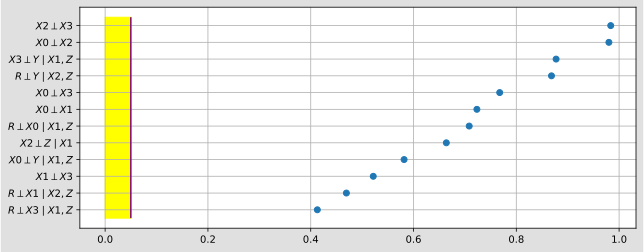

In [5]:
# this function explores all the CI between 2 variables and computes the p-values w.r.t to a csv file.
expl.independenceListForPairs(bn, data_path)

… with respect to a specific target.

{('Y', 'R', ('X2', 'Z')): 0.8684231094674687,
 ('Y', 'X0', ('X1', 'Z')): 0.5816487109659612,
 ('Y', 'X3', ('X1', 'Z')): 0.8774081450472305}

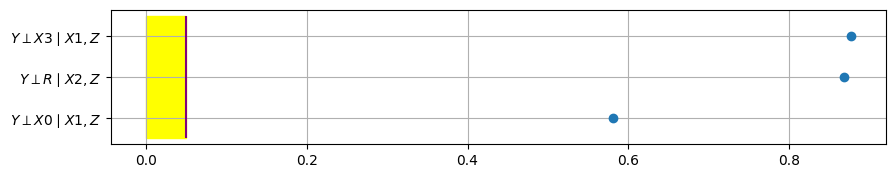

In [4]:
expl.independenceListForPairs(bn, data_path, target="Y")

## 2 - Visualizing information

Another view consists in showing the entropy on each node and the mutual informations on each arcs.

In [16]:
expl.showInformation(bn)

## 3 - ShapValues 

pyAgrum provides all three types of Shapley values—Conditional, Marginal, and Causal—through the classes ConditionalShapValues, MarginalShapValues, and CausalShapValues.<br>
These classes are specifically designed to explain posterior probabilities resulting from Bayesian network inference.<br>
Explanations are provided for each target class, making the framework well-suited for handling multi-class problems.<br>

In [3]:
train = pd.read_csv(data_path)

### 2.1 - Conditional Shapley Values 

In [8]:
# ConditionalShapValues requires a Bayesian Network and a target name (or target ID). The logit parameter is a boolean indicating whether to use the logit function instead of raw probabilities.
conditionalExplainer = expl.ConditionalShapValues(bn, 'Y', logit=True)

Once the ConditionalShapValues object is created, the main method to call is compute, which returns an Explanation object containing all the information related to the explanation.<br>
```python
compute(data: tuple(pd.DataFrame, bool) | None, N: int = 100)-> Explanation
```
The idea is to provide us with a dataset to be explained, and to indicate whether it contains the labels or the positions of the feature values used in the Bayesian network. Alternatively, you can set data to None and specify an integer value for N. In that case, we will generate a dataset using the Bayesian network and provide an explanation for it.

### 2.1.1 - Global Explanation

In [8]:
# The explanation with data set to None
conditionalExplanation = conditionalExplainer.compute(data=None, N=50)

In [9]:
conditionalExplanation = conditionalExplainer.compute(data=(train, False))

To obtain the feature importances, simply write :

In [10]:
# The result is provided for each target value.
conditionalExplanation.importances

{0: {'X2': 0.32716064437520076,
  'X1': 0.2533375405370653,
  'X0': 0.06176712200000174,
  'R': 0.05445633444152396,
  'X3': 0.10465402104047902,
  'Z': 0.5464180054433384},
 1: {'X2': 0.3271606443752008,
  'X1': 0.25333754053706536,
  'X0': 0.06176712200000175,
  'R': 0.05445633444152399,
  'X3': 0.10465402104047901,
  'Z': 0.5464180054433385}}

You can pass the object to be explained as a dictionary, like this :

In [11]:
instance = {'X2': [0, 1], 'X1': [1, 1], 'X0': [0, 1], 'R': [0, 0], 'Y': [1, 1], 'X3': [1, 1], 'Z': [0, 1]}
globalExpl = conditionalExplainer.compute(data=(instance, False))

### 2.1.2 - Local Explanation

If you want to explain a single instance, there’s no need to change anything—just specify which one.

In [12]:
localExpl = conditionalExplainer.compute((train.iloc[0], False))

To obtain the feature contributions, simply write :

In [13]:
localExpl._values

{0: {'X2': -0.20330620848406433,
  'X1': -0.09507935172769903,
  'X0': 0.0337329153702699,
  'R': 0.024202249066987182,
  'X3': -0.04129914759887278,
  'Z': 0.2515464162592886},
 1: {'X2': 0.20330620848406444,
  'X1': 0.09507935172769909,
  'X0': -0.033732915370269824,
  'R': -0.024202249066987244,
  'X3': 0.041299147598872786,
  'Z': -0.25154641625928875}}

You can pass the object to be explained as a dictionary, like this :

In [14]:
instance = {'X2': 0, 'X1': 1, 'X0': 0, 'R': 1, 'Y': 1, 'X3': 1, 'Z': 1}
localExpl = conditionalExplainer.compute((instance, False))

### 2.2 - Marginal Shapley Values 

The only difference between the Conditional Shapley Values syntax and the Marginal one lies in the instantiation of the explainer, as the Marginal approach requires a background dataset to perform computations.

In [15]:
background = train.sample(500)
marginalExplainer = expl.MarginalShapValues(bn=bn, target='Y', background=(background, False), logit=True)

Same idea: you can set background to None and specify an integer value for sample_size. In that case, we will generate the background dataset using the Bayesian network.

All other operations remain the same, since compute is a method of the ShapleyValues class, which is inherited by the three subclasses: ConditionalShapValues, MarginalShapValues, and CausalShapValues.

In [16]:
marginalExplanation = marginalExplainer.compute(data=(train, False))

### 2.3 - Causal Shapley Values 

The syntax is the same as Marginal.

In [17]:
background = train.sample(100)
causalExplainer = expl.CausalShapValues(bn=bn, target='Y', background=(background, False), logit=True)

In [ ]:
causalExplanation = causalExplainer.compute((train, False))

### 2.4 - Plots

PyAgrum provides three different plots: the waterfall plot for local explanations, the beeswarm plot for global explanations, and the bar plot, which can be used for both. All plots require an Explanation object as input (i.e., the one returned by the compute method), and for the waterfall and beeswarm plots, you also need to specify the target you want to visualize. For the bar plot, if no target is specified, PyAgrum will generate a multi-bar plot for all targets.

In [11]:
import pyagrum.explain.notebook as explnb

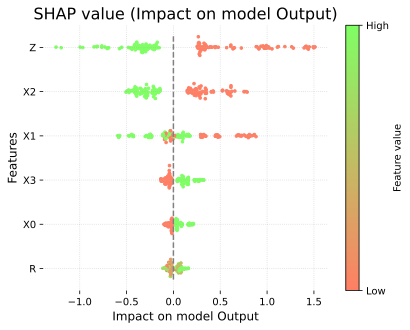

In [21]:
explnb.beeswarm(explanation=conditionalExplanation, y=1)

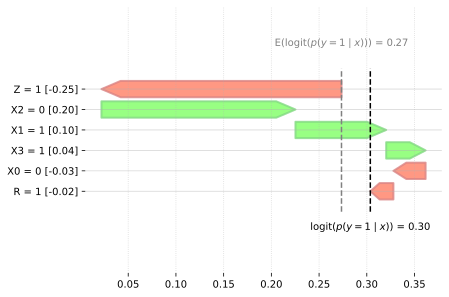

In [22]:
explnb.waterfall(explanation=localExpl, y=1)

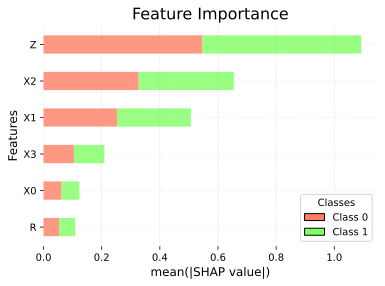

In [23]:
# Without specifying a target
explnb.bar(explanation=conditionalExplanation)

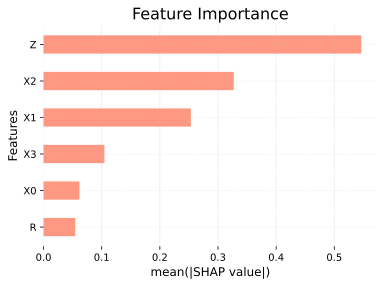

In [24]:
explnb.bar(explanation=conditionalExplanation, y=1)

You can also visualize Shapley Values directly on the BN. The `showShapValues` function returns a coloured graph that makes it easier to understand which variable is important and where it is located in the graph.

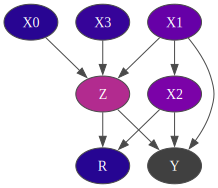

In [12]:
explnb.showShapValues(bn, conditionalExplanation)

### 2.5 - Partial explanations (Bayesian Networks)

If you have an instance with unobserved values, you can still explain it without modifying the Bayesian network.

In [25]:
instance = {'X2': 0, 'X1': 1, 'X0': 0, 'R': 1}

In [26]:
# We did not observe 'Z' and 'X3'
partexpl = conditionalExplainer.compute((instance, False))

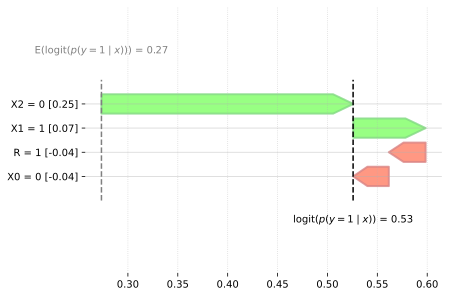

In [27]:
explnb.waterfall(partexpl, 1)

### 2.6 - Backward compatibility

The new version of the library is backward compatible, so existing code will continue to work without changes.

In [4]:
import pyagrum.lib.explain as explib

/Users/rayanenasri/Documents/Internships/aGrUMLab/.venv/lib/python3.13/site-packages/pyagrum/lib/explain.py:47: UserWarning: The module 'pyagrum.lib.explain' has been deprecated since version 2.2.1. Please use the 'pyagrum.explain' module instead.
  warnings.warn(


In [5]:
explainer = explib.ShapValues(bn, 'Y')

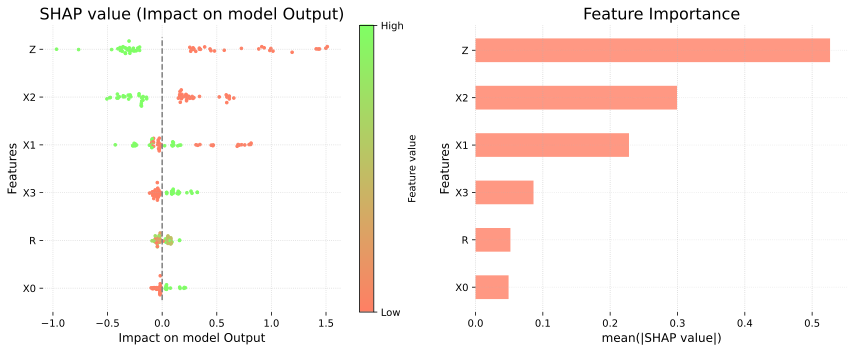

In [13]:
res= explainer.conditional(train.head(100), plot=True, plot_importance=True)

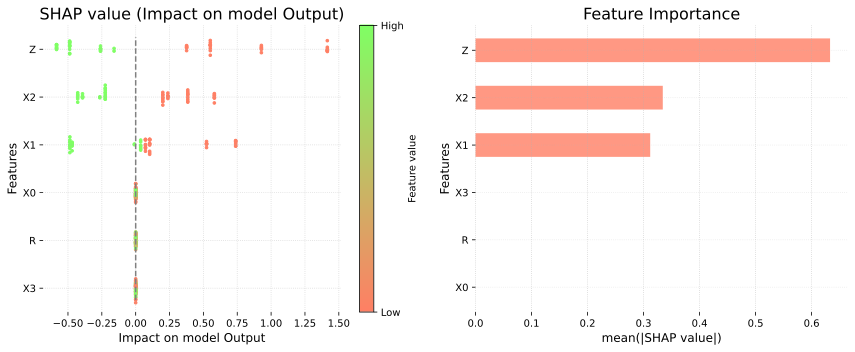

{'X2': 0.3343537559280226,
 'X1': 0.31189405252692737,
 'X0': 0.0,
 'R': 0.0,
 'X3': 0.0,
 'Z': 0.6330019577381352}

In [7]:
explainer.marginal(train.head(100), plot=True, plot_importance=True)

Since the `showShapValues` function existed in previous versions, it remains compatible with the earlier syntax.

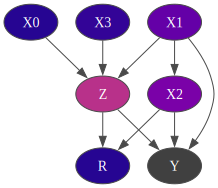

In [14]:
explib.showShapValues(bn, res)